# Coletar dados de tempo e distância através do CEP no Google Maps usando Python

### Introdução:
No mundo atual, dados precisos de tempo e distância são essenciais para uma ampla gama de aplicativos, desde logística até planejamento urbano. O Google Maps fornece um serviço poderoso chamado Distance Matrix API, que permite obter informações precisas sobre tempos de viagem e distâncias entre diferentes pontos. Neste artigo, você aprenderá como construir um processo para coletar esses dados utilizando Python e a API Distance Matrix do Google Maps.
Os dados obtidos são muito utilizados nas empresas para auxiliar na roteirização e demais aplicações que utilizam a geolocalização em seu negócio.

### Objetivo:
Será utilizado uma base de CEP com a origem e destino como referência para calcular o tempo e distância entre dois pontos, também enriquecer a base com os dados: BAIRRO, CIDADE, UF, IBGE e DDD.
No final será gerado um arquivo CSV com os dados obtidos para serem utilizados em um outro momento. A criação do arquivo será realizada através da função "writer.writerow" e pode muito bem ser modificada afim de simplificar o código com menos linhas de código ou algo do tipo.

### Configuração Inicial:

##### Distance Matrix
Antes de começar, você precisa ter uma conta no Google Cloud Platform (GCP) e criar um projeto para obter a chave de API necessária para acessar o serviço Distance Matrix. Siga as etapas de criação do projeto e geração da chave de API no console do GCP.
O serviço possui limitações no uso gratuito e pode haver cobranças caso a quantidade de requisições ultrapasse os limites estabelecidos, sugiro consultar a documentação para maiores detalhes em: https://developers.google.com/maps/documentation/javascript/distancematrix

##### VIACEP
Será utilizado o webservice gratuito para consultar o CEP através da url https://viacep.com.br/

##### Credenciais 
Renomear o arquivo "credenciais-modelo.json" para "credenciais.json" e altere o valor da variável "GoogleAPI_strKey" com a chave de acesso ao serviço do GCP.


In [1]:
# import de pacotes necessários
import pandas as pd
import json
import requests
import csv
import time
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# função para consulta de endereço utilizando o site VIACEP
def fn_consulta_viacep(cep):
    url = 'https://viacep.com.br/ws/' + cep + '/json/'
    endereco = json.loads(requests.get(url).text)
    
    return endereco

# faz o teste da função fn_consulta_viacep consultando um endereço
cep_origem = '01001000'
endereco = fn_consulta_viacep(cep_origem)
print(endereco['logradouro'] + ' - ' + endereco['bairro'] + ', ' + endereco['localidade'] + ', ' + endereco['uf'] + ', ' + endereco['cep'] + ', Brasil')

Praça da Sé - Sé, São Paulo, SP, 01001-000, Brasil


In [5]:
# faz a leitura do arquivo de credenciais
dir_json = "credenciais.json"
file = open(dir_json, 'r')
credencial = json.load(file)

# variavel com a sua chave de acesso a API do Google
strKey = credencial['credenciais'][0]['GoogleAPI_strKey']

In [6]:
# a API possui alguns modos de viagem podendo ser: BICYCLING, DRIVING, TRANSIT, WALKING 
modo = 'DRIVING'

# função para consulta de CEP origem destino Google API
def fn_consulta_rota(origem, destino, modo):
    strOrigem = origem.replace(' ', '+')
    strDestino = destino.replace(' ', '+')
    #, language='pt-BR'
    return requests.get('https://maps.googleapis.com/maps/api/distancematrix/json?units=metric&language=pt-BR&mode='+modo+'&origins='
                     +strOrigem+'&destinations='+strDestino+'&key='+strKey)

# faz o teste da função fn_consulta_rota com o endereço obtido no webservice VIACEP para o museu do ipiranga
origem = endereco['logradouro'] + ' - ' + endereco['bairro'] + ', ' + endereco['localidade'] + ', ' + endereco['uf'] + ', ' + endereco['cep'] + ', Brazil'
destino = "Avenida Nazaré - Ipiranga, São Paulo, SP, 04263-000, Brasil"
modo = 'transit'
response = fn_consulta_rota(origem, destino, modo)
rota = response.json()
print(rota)

{'destination_addresses': ['Av. Nazaré, 1-803 - Ipiranga, São Paulo - SP, 04263-000, Brasil'], 'origin_addresses': ['Praça da Sé - Sé, São Paulo - SP, 01001-000, Brasil'], 'rows': [{'elements': [{'distance': {'text': '6,3 km', 'value': 6285}, 'duration': {'text': '27 minutos', 'value': 1621}, 'status': 'OK'}]}], 'status': 'OK'}


### Se o resultado das funções der OK
Após os resultados das funções fn_consulta_viacep e fn_consulta_rota serem satisfatórios podemos prosseguir.
Caso apresente erro ao executar as funções verifique o código e a chave de API do Gooogle e tente novamente.

In [7]:
# função para realizar a consulta na API Distance Matrix do Google Maps e gerar o arquivo CSV com os resultados obtidos
def fn_consulta_api(df):
    
    # recebe o dataframe
    df = pd.DataFrame(data=df)
    
    # define as variável de apoio
    erros = 0

    # define o nome do arquivo conforme a data e hora de execução
    arquivo_id = datetime.today().strftime('%Y%m%d%H%M')
    arquivo = f"data\\ResultadoConsultaCEP_{arquivo_id}.csv"
    
    # lista a quantidade de registros para consultar em uma variável
    registros = len(df_sample)

    # verifica se existe CEP para consultar
    if registros > 0:

        # cria o arquivo CSV com o resultado da consulta
        with open(arquivo, mode='w', newline='') as csv_file:
            writer = csv.DictWriter(
                csv_file
                , fieldnames=["ID"
                              , "CEP_ORIGEM"
                              , "CEP_DESTINO"
                              , "ENDERECO_ORIGEM"
                              , "ENDERECO_DESTINO"
                              , "LOCAL"
                              , "DISTANCIA"
                              , "DISTANCIA_VL"
                              , "TEMPO"
                              , "TEMPO_VL"
                              , "STATUS"
                              , "MODO"
                              , "LOGRADOURO"
                              , "BAIRRO"
                              , "CIDADE"
                              , "UF"
                              , "IBGE"
                              , "DDD"
                              , "OBSERVACAO"
                              , "ATUALIZADO EM"]
                , delimiter=';'
                , quotechar='"'
            )

            # escreve o cabeçalho no arquivo
            writer.writeheader()

            # faz a consulta da base de cpf
            print('Realizando a consulta...')
            # get da variaveis data hora inicio
            datatime_ini = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
            print(f"Processo iniciado em: {datatime_ini}")

            # aplica um for para cada registro do dataframe
            for index, row in df_sample.iterrows():

                # flag variaveis
                atualizado_em = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
                cep_origem = row['cep_origem'].replace('-', '').rstrip()
                cep_destino = row['cep_destino'].replace('-', '').rstrip()
                endereco_destino = row['endereco_destino']
                local = row['local']

                # consulta o endereço de origem em VIACEP
                endereco = fn_consulta_viacep(cep_origem)

                try:
                    endereco_origem = endereco['logradouro'] + ' - ' + endereco['bairro'] + ', ' + endereco['localidade'] + ' - ' + endereco['uf'] + ', '  + endereco['cep'] + ', Brazil'
                    status_endereco = 'OK'
                except:
                    status_endereco = 'ERRO'

                if status_endereco == 'OK':

                    # faz a consulta na API
                    try:                
                        # faz a consulta do CEP no Google API
                        # aguarda antes de executar o próximo passo
                        time.sleep(3)
                        response = fn_consulta_rota(endereco_origem, endereco_destino, modo)
                        rota = response.json()

                        # se a consulta retornar dados
                        if rota:

                            status = rota['rows'][0]['elements'][0]['status']

                            if status == 'NOT_FOUND' or status == 'ZERO_RESULTS':
                                status_rota = 'ERRO'
                                observacao = 'Falha ao realizar a consulta da rota NOT_FOUND/ZERO_RESULTS'
                            else:
                                status_rota = rota['rows'][0]['elements'][0]['status']
                                observacao = 'Rota OK'

                            try:
                                # grava o resultado no arquivo
                                writer.writerow({"ID": index
                                                , "CEP_ORIGEM": row['cep_origem']
                                                 , "CEP_DESTINO": row['cep_destino']
                                                 , "ENDERECO_ORIGEM": rota['origin_addresses'][0]
                                                 , "ENDERECO_DESTINO": rota['destination_addresses'][0]
                                                 , "LOCAL": row['local']
                                                 , "DISTANCIA": rota['rows'][0]['elements'][0]['distance']['text']
                                                 , "DISTANCIA_VL": str(rota['rows'][0]['elements'][0]['distance']['value'])
                                                 , "TEMPO": rota['rows'][0]['elements'][0]['duration']['text']
                                                 , "TEMPO_VL": str(rota['rows'][0]['elements'][0]['duration']['value'])
                                                 , "STATUS": rota['rows'][0]['elements'][0]['status']
                                                 , "MODO": modo
                                                 , "LOGRADOURO": endereco['logradouro']
                                                 , "BAIRRO": endereco['bairro']
                                                 , "CIDADE": endereco['localidade']
                                                 , "UF": endereco['uf']
                                                 , "IBGE": endereco['ibge']
                                                 , "DDD": endereco['ddd']
                                                 , "OBSERVACAO": observacao
                                                 , "ATUALIZADO EM": atualizado_em
                                            })
            
                            except Exception as e:
                                # falha ao gravar o resultado no arquivo
                                # acrescenta 1 a quantidade de erros e aguarda antes de executar o próximo passo
                                erros += 1
                                time.sleep(5) 
                                observacao = 'Falha ao gravar o resultado no arquivo'

                                # grava o resultado no arquivo
                                writer.writerow({"ID": index
                                                , "CEP_ORIGEM": row['cep_origem']
                                                 , "CEP_DESTINO": row['cep_destino']
                                                 , "ENDERECO_ORIGEM": endereco_origem
                                                 , "ENDERECO_DESTINO": endereco_destino
                                                 , "LOCAL": row['local']
                                                 , "DISTANCIA": "NULL"
                                                 , "DISTANCIA_VL": 0
                                                 , "TEMPO": "NULL"
                                                 , "TEMPO_VL": 0
                                                 , "STATUS": "ERRO"
                                                 , "MODO": modo
                                                 , "LOGRADOURO": endereco['logradouro']
                                                 , "BAIRRO": endereco['bairro']
                                                 , "CIDADE": endereco['localidade']
                                                 , "UF": endereco['uf']
                                                 , "IBGE": endereco['ibge']
                                                 , "DDD": endereco['ddd']
                                                 , "OBSERVACAO": observacao
                                                 , "ATUALIZADO EM": atualizado_em
                                            })

                        else:
                            erros += 1
                            time.sleep(5) # aguarda para realizar o próximo passo
                            print("Rota não definida")

                    except Exception as e:
                        # falha ao realizar a consulta na API Google
                        # acrescenta 1 a quantidade de erros e aguarda antes de executar o próximo passo
                        erros += 1
                        time.sleep(5)
                        print(f"[ERRO {index}] {e}")
                        print("Falha ao realizar a consulta na API Google")
                        print(str(index) + " [ERRO] Origem: " + cep_origem + " | Destino: " + cep_destino)
                        print(e)                    

                else:
                    # falha ao realizar a consulta na API VIACEP
                    # acrescenta 1 a quantidade de erros e aguarda antes de executar o próximo passo
                    erros += 1
                    time.sleep(5) 
                    
                    # grava o resultado no arquivo
                    writer.writerow({"ID": index
                                     , "CEP_ORIGEM": row['cep_origem']
                                     , "CEP_DESTINO": row['cep_destino']
                                     , "ENDERECO_ORIGEM": endereco_origem
                                     , "ENDERECO_DESTINO": endereco_destino
                                     , "LOCAL": row['local']
                                     , "DISTANCIA": "NULL"
                                     , "DISTANCIA_VL": 0
                                     , "TEMPO": "NULL"
                                     , "TEMPO_VL": 0
                                     , "STATUS": "ERRO"
                                     , "MODO": modo
                                     , "LOGRADOURO": "NULL"
                                     , "BAIRRO": "NULL"
                                     , "CIDADE": "NULL"
                                     , "UF": "NULL"
                                     , "IBGE": "NULL"
                                     , "DDD": "NULL"
                                     , "OBSERVACAO": "Falha ao realizar a consulta na API VIACEP"
                                     , "ATUALIZADO EM": atualizado_em
                                    })


    # flag data hora fim 
    datatime_fim = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
    datatime_ini = datetime.strptime(datatime_ini, '%Y-%m-%d %H:%M:%S')
    datatime_fim = datetime.strptime(datatime_fim, '%Y-%m-%d %H:%M:%S')
    duracao = datatime_fim - datatime_ini

    # faz o print dos resultados
    print(f"Processo finalizado em: {datatime_fim}")
    print(f"Duração: {duracao}")
    print(f"Total de {str(registros)} registros atualizados e {str(erros)} erro(s)")
    print(f"Criado o arquivo {arquivo} com os dados da consulta")
    
    return

### Realizado a coleta de dados
Utiliar a base com o CEP de origem e destino de endereços para serem cálculados

In [8]:
# abre o arquivo excel
df = pd.read_excel('data\\Base CEP.xlsx', sheet_name='Base')

In [9]:
# exibe um resumo das variáveis contidas no arquivo
df.describe()

,cep_origem,cep_destino,endereco_destino,local
count,23863,23863,23863,23863
unique,14774,7,7,7
top,08475-180,04263-000,"Avenida Nazaré - Ipiranga, São Paulo, SP, 0426...",Ipiranga
freq,5,6489,6489,6489


In [10]:
# faz a contagem dos valores pela variavél local
df['local'].value_counts()

Ipiranga      6489
Pacaembu      5351
Osasco        3812
Bela Vista    3251
República     2845
Butantã       1113
Pinheiros     1002
Name: local, dtype: int64

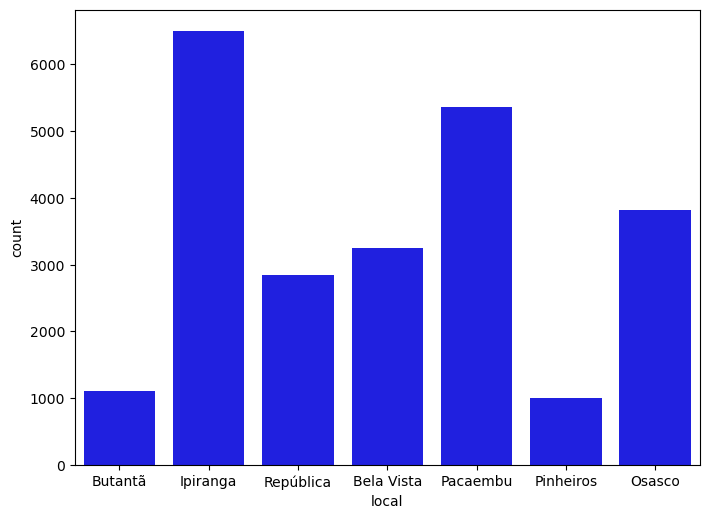

In [11]:
# exibe de forma gráfica a quandidade de registros da variavél local 
cats = ['local']
plt.figure(figsize = (20, 10))
for i in range(0, len(cats)):
    plt.subplot(2, 3, i+1)
    sns.countplot(x = df[cats[i]], color = 'blue', orient = 'v')
    plt.tight_layout()

In [12]:
# vamos criar um dataframe de amostra randomica ao invés do dataframe completo
df_sample = df.sample(n=100, random_state=42)

# exibe os primeiros dados do dataframe
df_sample.head()

,cep_origem,cep_destino,endereco_destino,local
963,05136-000,12020-363,"Rua Coronel Xavier de Toledo - República, São ...",República
960,05135-160,01234-010,"Praça Charles Miller - Pacaembu, São Paulo, SP...",Pacaembu
2516,03587-080,04263-000,"Avenida Nazaré - Ipiranga, São Paulo, SP, 0426...",Ipiranga
20179,08473-450,01234-010,"Praça Charles Miller - Pacaembu, São Paulo, SP...",Pacaembu
199,08560-030,04263-000,"Avenida Nazaré - Ipiranga, São Paulo, SP, 0426...",Ipiranga


In [13]:
# a consulta será executada utilizando o dataframe de amostra
fn_consulta_api(df_sample)

Realizando a consulta...
Processo iniciado em: 2023-10-17 21:26:17
Processo finalizado em: 2023-10-17 21:33:39
Duração: 0:07:22
Total de 100 registros atualizados e 1 erro(s)
Criado o arquivo data\ResultadoConsultaCEP_202310172126.csv com os dados da consulta


### Resumo
O código apresentado mostra como utilizar a API do Google Maps para obter informações sobre a distância e tempo de deslocamento entre dois endereços. Para isso, utiliza a biblioteca requests para enviar requisições HTTP e a biblioteca googlemaps para obter informações de latitude e longitude a partir de endereços. A conclusão que pode ser tirada desse código é que as APIs de serviços de geolocalização e mapeamento, como a do Google Maps, podem ser muito úteis para aplicações que necessitam de informações geográficas, como rotas e localizações. Com essas informações, é possível criar soluções para logística, transporte, serviços de entrega, entre outras aplicações.
